In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import copy
from sklearn.metrics import accuracy_score,f1_score,roc_curve,precision_recall_curve,average_precision_score,auc
from sklearn.metrics import precision_score, recall_score, f1_score,confusion_matrix,matthews_corrcoef,roc_auc_score
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,TensorDataset,DataLoader
import pandas as pd
from PIL import Image
import numpy as np
import random

In [3]:
BATCH_SIZE = 128
ran = [i for i in range(30000)]
testlist = []
trainlist = random.sample(ran,27000)
for j in ran:
    if(j not in trainlist):
        testlist.append(j)

In [4]:
#https://blog.csdn.net/sunqiande88/article/details/80100891 Resnet参考
class BasicBlock(nn.Module):
    def __init__(self, inchannel, outchannel, stride=1):
        super(BasicBlock, self).__init__()
        self.left = nn.Sequential(
            nn.Conv2d(inchannel, outchannel, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(outchannel),
            nn.ReLU(inplace=True),
            nn.Conv2d(outchannel, outchannel, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(outchannel)
        )
        self.shortcut = nn.Sequential()
        if stride != 1 or inchannel != outchannel:
            self.shortcut = nn.Sequential(
                nn.Conv2d(inchannel, outchannel, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(outchannel)
            )

    def forward(self, x):
        out = self.left(x)
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [6]:
class Model(nn.Module):
    def __init__(self, BasicBlock,layers, num_classes=10):
        super(Model, self).__init__()
        self.inchannel = 64
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        #self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self.make_layer(BasicBlock, 64, layers[0], stride=1)
        self.layer2 = self.make_layer(BasicBlock, 128,layers[1], stride=2)
        self.layer3 = self.make_layer(BasicBlock, 256,layers[2], stride=2)
        self.layer4 = self.make_layer(BasicBlock, 512,layers[3], stride=2)
        self.fc = nn.Linear(512, num_classes)

    def make_layer(self, block, channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)   #strides=[1,1]
        layers = []
        for stride in strides:
            layers.append(block(self.inchannel, channels, stride))
            self.inchannel = channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        #out = self.maxpool(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [ ]:
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

In [ ]:
class Modelmore(nn.Module):

    def __init__(self, block, layers, num_classes=10):
        self.inplanes = 64
        super(Modelmore, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1,
                               bias=False)

        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        #self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(4, stride=1)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        #x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [ ]:
#添加椒盐噪声
class salt_and_pepper_noise(object):
    def __init__(self,proportion = 0.03):
        self.proportion = proportion

    def __call__(self,img):
        noise_img = img
        height, width = noise_img.shape[0], noise_img.shape[1]
        num = int(height * width * self.proportion)  # 多少个像素点添加椒盐噪声
        for i in range(num):
            w = random.randint(0, width - 1)
            h = random.randint(0, height - 1)
            if random.randint(0, 1) == 0:
                noise_img[h, w] = 0
            else:
                noise_img[h, w] = 255
        return noise_img

In [ ]:
#添加高斯噪声
class gauss_noise(object):
    def __init__(self):
        self.mu = 0
        self.sigma = 0.5

    def __call__(self,image):
        img = image
        for i in range(img.shape[0]):
            for j in range(img.shape[1]):
                img[i, j] = img[i, j] + random.gauss(mu=self.mu, sigma=self.sigma)
        img[img > 255] = 255
        img[img < 0] = 0
        return img

In [7]:
class TrainDataset(Dataset):
    def __init__(self):
        train_npy = np.load("train.npy")
        self.arr = np.array(train_npy[trainlist], dtype=np.float32)
        self.arr.resize((27000, 1, 28, 28))
        #self.train_data = Image.fromarray(arr)
        self.train_data = torch.from_numpy(self.arr)
        #self.train_label = pd.read_csv("train.csv",usecols=[1])
        labelnp = np.loadtxt("train.csv", delimiter=",", skiprows=1, usecols=[1],dtype=np.longlong)
        self.train_label = torch.from_numpy(labelnp[trainlist])
        self.len = self.arr.shape[0]
        self.transform=transforms.Compose([
            transforms.ToPILImage(),
            #transforms.RandomResizedCrop(28),
            transforms.RandomHorizontalFlip(),
            #transforms.Normalize(std=(0.5,0.5,0.5),mean=(0.5,0.5,0.5)),
            transforms.RandomRotation((-15,15)),
            transforms.ToTensor(),
            #gauss_noise(),
            #normalize,
        ])

    def __len__(self):
        return self.len
    def __getitem__(self,idx):
        return self.transform(self.train_data[idx]), self.train_label[idx]

In [8]:
#验证集
class PreDataset(Dataset):
    def __init__(self):
        test_npy = np.load("train.npy")
        arr = np.array(test_npy[testlist], dtype=np.float32)
        arr.resize((3000, 1, 28, 28))
        self.test_data = torch.from_numpy(arr)
        #self.train_label = pd.read_csv("train.csv",usecols=[1])
        labelnp = np.loadtxt("train.csv", delimiter=",", skiprows=1, usecols=[1],dtype=np.longlong)
        self.test_label = torch.from_numpy(labelnp[testlist])
        self.len = self.test_data.shape[0]
        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.ToTensor(),
            # normalize,
        ])
    def __len__(self):
        return self.len
    def __getitem__(self,idx):
        return self.transform(self.test_data[idx]), self.test_label[idx]

In [ ]:
model = Model(BasicBlock,[2,2,2,2]).cuda() #实例化卷积层
loss = nn.CrossEntropyLoss() #损失函数选择，交叉熵函数
train_dataset = TrainDataset()
pre_dataset = PreDataset()
train_loader = DataLoader(dataset=train_dataset,batch_size=BATCH_SIZE,shuffle=True)
pre_loader = DataLoader(dataset=pre_dataset,batch_size=BATCH_SIZE,shuffle=False)

In [73]:
optimizer = optim.Adam(model.parameters(),lr = 0.001)
num_epochs = 40
losses = []
acces = []
eval_losses = []
eval_acces = []

for echo in range(num_epochs):
    train_loss = 0  # 定义训练损失
    train_acc = 0  # 定义训练准确度
    model.train()  # 将网络转化为训练模式
    for i, (X, label) in enumerate(train_loader):  # 使用枚举函数遍历train_loader
        # X = X.view(-1,784)       #X:[64,1,28,28] -> [64,784]将X向量展平
        X = Variable(X).cuda()          #包装tensor用于自动求梯度
        #print(X.size())
        label = Variable(label).cuda()
        #print(X.size())
        #print(label)
        out = model(X)  # 正向传播
        #print(out)
        lossvalue = loss(out, label)  # 求损失值
        optimizer.zero_grad()  # 优化器梯度归零
        lossvalue.backward()  # 反向转播，刷新梯度值
        optimizer.step()  # 优化器运行一步，注意optimizer搜集的是model的参数

        # 计算损失
        train_loss += float(lossvalue)
        # 计算精确度
        _, pred = out.max(1)
        num_correct = (pred == label).sum()
        acc = int(num_correct) / X.shape[0]
        train_acc += acc

    losses.append(train_loss / len(train_loader))
    acces.append(train_acc / len(train_loader))
    print("echo:" + ' ' + str(echo))
    print("lose:" + ' ' + str(train_loss / len(train_loader)))
    print("accuracy:" + ' ' + str(train_acc / len(train_loader)))

echo: 0
lose: 0.04335890715209088
accuracy: 0.9858535742496051


In [74]:
label_all = None
pred_all = None
pred_pro_all = None
model.eval() #模型转化为评估模式
with torch.no_grad():
    for X, label in pre_loader:
        # X = X.view(-1,784)
        X = Variable(X).cuda()
        label = Variable(label).cuda()
        testout = model(X)
        testloss = loss(testout, label)
        # eval_loss += float(testloss)

        _, pred = testout.max(1)
        if label_all is None:
            label_all = label
        else:
            label_all = torch.cat([label_all, label])

        if pred_all is None:
            pred_all = torch.cat([pred])
        else:
            pred_all = torch.cat([pred_all, pred])

        if pred_pro_all is None:
            pred_pro_all = torch.cat([torch.sigmoid(testout)])
        else:
            pred_pro_all = torch.cat([pred_pro_all, torch.sigmoid(testout)])
    #     num_correct = (pred == label).sum()
    #     acc = int(num_correct) / X.shape[0]
    #     eval_acc += acc

y_test = label_all.cpu().detach().numpy()
#print(y_test)
y_pred = pred_all.cpu().detach().numpy()
#print(y_pred)
y_pred_pro = pred_pro_all.cpu().detach().numpy()

print('ACC:%.7f' %accuracy_score(y_true=y_test, y_pred=y_pred))
print('Precision-macro:%.7f' %precision_score(y_true=y_test, y_pred=y_pred,average='macro'))
print('Recall-macro:%.7f' %recall_score(y_true=y_test, y_pred=y_pred,average='macro'))
print('F1-macro:%.7f' %f1_score(y_true=y_test, y_pred=y_pred,average='macro'))

ACC:0.9086667
Precision-macro:0.9092511
Recall-macro:0.9097593
F1-macro:0.9092555


In [47]:
torch.save(model.state_dict(), "Resnet.pkl")
fpr = dict()
tpr = dict()
roc_auc = dict()
average_precision = dict()
recall = dict()
precision = dict()
for i in range(10):
    y_test2 = copy.deepcopy(y_test)
    y_test2[y_test2!=i] = 10
    y_test2[y_test2==i] = 1
    y_test2[y_test2==10] = 0
    y_pred_pro2 = y_pred_pro[:,i]
    #print(y_pred_pro2)
    #print(y_test2)
    fpr[i], tpr[i], _ = roc_curve(y_test2, y_pred_pro2)
    roc_auc[i] = roc_auc_score(y_test2,y_pred_pro2)


    average_precision[i] = average_precision_score(y_test2, y_pred_pro2)
    #print('Average precision-recall score: %.7f' % average_precision)
    precision[i], recall[i], _ = precision_recall_curve(y_test2,y_pred_pro2)

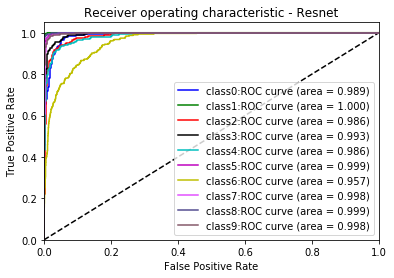

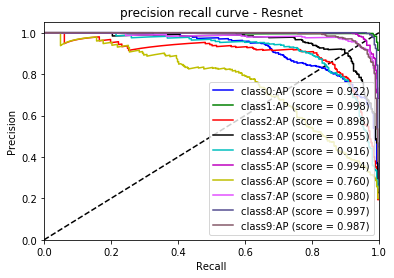

In [48]:
colors = ['b','g','r','k','c','m','y','#e24fff','#524C90','#845868']
plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic - Resnet')
for i in range(10):
    plt.plot(fpr[i], tpr[i], label="class" + str(i) + ':ROC curve (area = %0.3f)' % roc_auc[i],color=colors[i])
plt.legend(loc="lower right")
plt.savefig("roc.png")


# Plot of a ROC curve for a specific class
colors = ['b','g','r','k','c','m','y','#e24fff','#524C90','#845868']
plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('precision recall curve - Resnet')
for i in range(10):
    plt.plot(recall[i], precision[i], label="class" + str(i) + ':AP (score = %0.3f)' % average_precision[i],color=colors[i])
plt.legend(loc="lower right")
plt.savefig("pr.png")

In [62]:
#测试集
class TestDataset(Dataset):
    def __init__(self):
        test_npy = np.load("test.npy")
        arr = np.array(test_npy[:], dtype=np.float32)
        arr.resize((5000, 1, 28, 28))
        self.test_data = torch.from_numpy(arr)
        self.len = self.test_data.shape[0]
        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.ToTensor(),
            # normalize,
        ])
    def __len__(self):
        return self.len
    def __getitem__(self,idx):
        return self.transform(self.test_data[idx])

In [63]:
test_dataset = TestDataset()
test_loader = DataLoader(dataset=test_dataset,batch_size=BATCH_SIZE,shuffle=False)

In [64]:
label_all = None
pred_all = None
pred_pro_all = None
model.eval() #模型转化为评估模式
with torch.no_grad():
    for X in test_loader:
        # X = X.view(-1,784)
        X = Variable(X).cuda()
        # label = Variable(label)#.cuda()
        testout = model(X)
        # testloss = loss(testout,label)
        # eval_loss += float(testloss)

        _, pred = testout.max(1)

        if pred_all is None:
            pred_all = torch.cat([pred])
        else:
            pred_all = torch.cat([pred_all, pred])

        if pred_pro_all is None:
            pred_pro_all = torch.cat([torch.sigmoid(testout)])
        else:
            pred_pro_all = torch.cat([pred_pro_all, torch.sigmoid(testout)])
#     num_correct = (pred == label).sum()
#     acc = int(num_correct) / X.shape[0]
#     eval_acc += acc

#y_test = label_all.cpu().detach().numpy()
#print(y_test)
y_pred = pred_all.cpu().detach().numpy()
#print(y_pred)
y_pred_pro = pred_pro_all.cpu().detach().numpy()

In [65]:
import csv
def writecsv(pred_all):
    #with open('submit2.csv', 'r+')as f:
        #f.truncate()
    with open('submit.csv', 'w', newline='')as f:
        csv_write = csv.writer(f, dialect='excel')
        csv_write.writerow(['image_id','label'])
        for i in range(5000):
            csv_write.writerow([i,pred_all[i].item()])

In [66]:
writecsv(pred_all)